# String Model Fit of Kob-Andersen Model under constant V

In [191]:
import os, sys, glob
import numpy as np
from subprocess import call
from scipy.optimize import curve_fit

PresList = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
N = len(PresList)
List = ['R{:03d}'.format(int(100*PresList[i])) for i in range(N)]


## Basic parameters

In [ ]:
#Parameters From Arrhenius Fit
TA = [0.9,1.42,2.04,2.78,3.57,4.5,5.88,7.26,8.93,]
LA = [1.44,1.46,1.5,1.52,1.56,1.607,1.62,1.65,1.685,]
TauA =[3.529,2.516,2.17,1.96,2.03,2.144,1.858,1.848,1.813]
DHo = [2.693,4.063,5.86,8.13,11.11,14.955,19.35,24.686,31.1865]
Ao = [0.17,0.1398,0.1184,0.1020,0.086,0.07466,0.066,0.0592,0.0531]


Data_Collection = []
Data_LT_Collection = []
Data_HT_Collection = []
for i in range(N):
    ## dynamic properties
    Temp = np.loadtxt(f'./Data/{List[i]}/Thermo')[:,2]
    Tau = np.loadtxt(f'./Data/{List[i]}/Tau2_FSQ')[:, 0]
    ASL = np.loadtxt(f'./Data/{List[i]}/Peak1_ASL')[:, 2]
    DeltaG = Temp*np.log(Tau/Ao[i])
    Data = np.zeros((len(Temp), 4))
    Data[:,0] = Temp
    Data[:,1] = Tau
    Data[:,2] = ASL/LA[i]
    Data[:,3] = DeltaG

    Data_Collection.append(Data)
    
    Data_LT = Data[Temp <= TA[i]]
    Data_LT_Collection.append(Data_LT)
    Data_HT = Data[Temp > TA[i]]
    Data_HT_Collection.append(Data_HT)

## Fit the model include entropy


In [193]:
DeltaSo = np.zeros(N)
DeltaHo = np.zeros(N)
for i in range(N):
    X = Data_LT_Collection[i][:,0]           # T            
    ASL_Norm = Data_LT_Collection[i][:,2]	              
    Y = np.log(Data_LT_Collection[i][:,1])	# L/LA (T < TA)

    def func(X, DSo):
        T,ASL_Norm=X[:,0],X[:,1]
        y = np.log(TauA[i]) + (DHo[i]/T - DSo)*(ASL_Norm) - (DHo[i]/TA[i] - DSo)
        return (y)

    XX = np.column_stack((X,ASL_Norm))
    Y = np.array(Y)
    popt, pcov = curve_fit(func, XX, Y, p0=[0.8])
    DeltaHo[i] = DHo[i]
    DeltaSo[i] = popt[0]

In [194]:
X = [];Y = []
for i in range(N):

    Tauo = TauA[i]*np.exp(DeltaSo[i] - DeltaHo[i]/TA[i])

    Temp = Data_LT_Collection[i][:,0] 
    Tau = Data_LT_Collection[i][:,1]
    ASL_Norm = Data_LT_Collection[i][:,2]

    X0= (DeltaHo[i] - DeltaSo[i]*Temp)*ASL_Norm/Temp
    Y0 = np.log(Tau/Tauo)
    X.append(X0)
    Y.append(Y0)

### plot the model

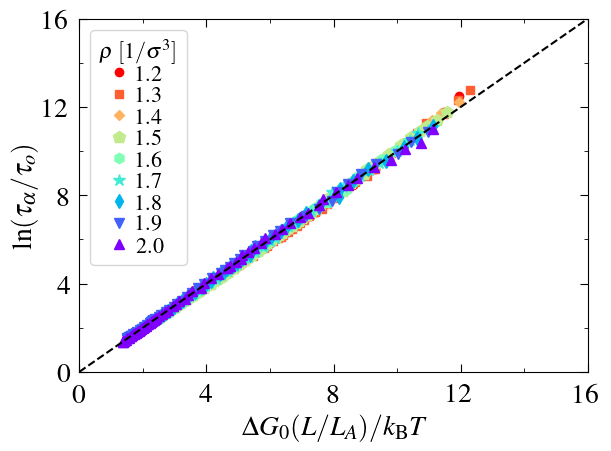

In [195]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({"text.usetex": True,"font.family": "serif",})
Mark_Type = ['o', 's', 'D', 'p', 'h', '*', 'd', 'v', '^', '<', '>']
Mark_Size = [4, 3.5, 3.5, 6.0, 5, 6, 5, 4.5, 4.5, 4.5, 4.5]
cm = plt.get_cmap('rainbow')

fig, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4.4), constrained_layout=True)

ax1.tick_params(axis='x', which='major', direction='in', top=True, right=True, length=6, pad=8, labelsize=20)
ax1.tick_params(axis='y', which='major', direction='in', top=True, right=True, length=6, pad=6, labelsize=20)
ax1.tick_params(axis='x', which='minor', direction='in', top=True, right=True, length=3, pad=6, labelsize=20)
ax1.tick_params(axis='y', which='minor', direction='in', top=True, right=True, length=3, pad=6,  labelsize=20)


ax1.axis([0.0, 16.0, 0.0, 16.0])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
for i in range(N):
    ax1.plot(X[i], Y[i],'{}'.format(Mark_Type[i]), ms=1.5*Mark_Size[i], c=cm(1-1.0*i/(N-1)),label = f'{PresList[i]}')
ax1.legend( loc='upper left', ncol=1, labelspacing=0.05, columnspacing=0.2, handlelength=0.5, handletextpad=0.5,fontsize=16, title=r'$\rho\ [1/\sigma^3]$', title_fontsize=16)

ax1.set_xlabel(r'$\Delta G_0(L/L_A)/k_{\mathrm{B}}T$', fontsize=20)
ax1.set_ylabel(r'$\ln(\tau_{\alpha}/\tau_o)$', fontsize=20)

x = np.linspace(0, 16, 100)
y = x
ax1.plot(x, y, '--', c='k', linewidth=1.5)


## Fit the model without entropy

In [ ]:
tauo = np.zeros(N)
DeltaGo = np.zeros(N)
for i in range(N):
    X = Data_LT_Collection[i][:,0]           # T
    ASL_Norm = Data_LT_Collection[i][:,2]
    Y = np.log(Data_LT_Collection[i][:,1])	# L/LA (T < TA)
    def func(X,tauo, DGo):
        T,ASL_Norm=X[:,0],X[:,1]
        y = tauo + (DGo/T )*(ASL_Norm)
        return (y)
    XX = np.column_stack((X,ASL_Norm))
    popt, pcov = curve_fit(func, XX, Y, p0=[0.8,0.8])
    tauo[i] = np.exp(popt[0])
    DeltaGo[i] = popt[1]


In [ ]:
X1  = [];Y1 = []
for i in range(N):

    Temp = Data_LT_Collection[i][:,0] 
    Tau = Data_LT_Collection[i][:,1]
    ASL_Norm = Data_LT_Collection[i][:,2]

    X0 = (DeltaGo[i])*ASL_Norm/Temp
    Y0 = np.log(Tau/tauo[i])
    X1.append(X0)
    Y1.append(Y0)


### plot the model

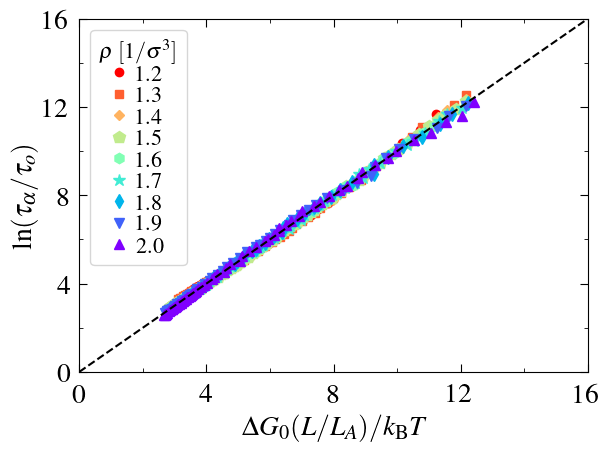

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({"text.usetex": True,"font.family": "serif",})
Mark_Type = ['o', 's', 'D', 'p', 'h', '*', 'd', 'v', '^', '<', '>']
Mark_Size = [4, 3.5, 3.5, 6.0, 5, 6, 5, 4.5, 4.5, 4.5, 4.5]
cm = plt.get_cmap('rainbow')

fig, ((ax1)) = plt.subplots(1, 1, figsize=(6, 4.4), constrained_layout=True)

ax1.tick_params(axis='x', which='major', direction='in', top=True, right=True, length=6, pad=8, labelsize=20)
ax1.tick_params(axis='y', which='major', direction='in', top=True, right=True, length=6, pad=6, labelsize=20)
ax1.tick_params(axis='x', which='minor', direction='in', top=True, right=True, length=3, pad=6, labelsize=20)
ax1.tick_params(axis='y', which='minor', direction='in', top=True, right=True, length=3, pad=6,  labelsize=20)

ax1.axis([0.0, 16.0, 0.0, 16.0])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))

for i in range(N):
    ax1.plot(X1[i], Y1[i],'{}'.format(Mark_Type[i]), ms=1.5*Mark_Size[i], c=cm(1-1.0*i/(N-1)),label = f'{PresList[i]}')

ax1.legend( loc='upper left', ncol=1, labelspacing=0.05, columnspacing=0.2, handlelength=0.5, handletextpad=0.5,fontsize=16, title=r'$\rho\ [1/\sigma^3]$', title_fontsize=16)

ax1.set_xlabel(r'$\Delta G_0(L/L_A)/k_{\mathrm{B}}T$', fontsize=20)
ax1.set_ylabel(r'$\ln(\tau_{\alpha}/\tau_o)$', fontsize=20)

x = np.linspace(0, 16, 100)
y = x
ax1.plot(x, y, '--', c='k', linewidth=1.5)